Perform a network projection of this bipartite network using `simple weights`. The unipartite projection should only contain nodes of type 1 (|V1| = 248). How dense is the projection?

In [1]:
import networkx as nx

# Load the data
G = nx.read_edgelist("data.txt")

# Let's figure out which node is of which type
nodes = nx.algorithms.bipartite.basic.sets(G)
rows = sorted(list(nodes[0]))
cols = sorted(list(nodes[1]))

In [2]:
# We'll project on nodes of type a
if "a1" in rows:
   nodes = rows
else:
   nodes = cols

# Let's get the bipartite adjacency matrix
T = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, row_order = nodes)

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\2177689248.py:8: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  T = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, row_order = nodes)


In [3]:
# If we multiply the bipartite adjacency matrix with its transpose we obtain the number of
# common ones between two rows, i.e. the number of common neighbors between the nodes.
U = T * T.T

# We set the diagonal to zero because we don't care about self loops
U.setdiag(0)
U.eliminate_zeros()

In [4]:
# We get the projected graph back. We relabel to recover the original node IDs
G = nx.from_scipy_sparse_matrix(U)
G = nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

# Graph is super dense! 40%
print(nx.density(G))

0.4097231291628575


C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\1818056177.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(U)


Perform a network projection of the bipartite network used for Exercise 23.1 using `cosine and Pearson weights`. What is the Pearson correlation of these weights compared with the ones from the previous question?

In [5]:
import numpy as np 
import pandas as pd
import networkx as nx
from sklearn.metrics import pairwise_distances

# We make the code from the previous question into its own function
def simple(network, nodes):
   T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
   U = T * T.T
   U.setdiag(0)
   U.eliminate_zeros()
   G = nx.from_scipy_sparse_matrix(U)
   return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

In [6]:
# We make functions to calculate alternative projections. The scheme is the same:
# calculate pairwise distances from the bipartite adjacency matrix and make them
# into similarity measures.
def cosine(network, nodes):
   T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
   # Since this is a distance, we take the inverse to make it into a similarity.
   # Maximum possible cosine distance is 1, so we take one minus it. If the two nodes
   # were identical, this measure equals to 1, if they were the maximum posible far
   # apart, this measure is zero.
   j_dist = 1.0 - pairwise_distances(T, metric = "cosine", n_jobs = -1)
   np.fill_diagonal(j_dist, 0)
   G = nx.from_numpy_matrix(j_dist)
   return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

def pearson(network, nodes):
   T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
   # Correlation distance maximum is 2 (corresponding to pearson correlation of -1).
   j_dist = (2.0 - pairwise_distances(T.todense(), metric = "correlation", n_jobs = -1)) / 2
   np.fill_diagonal(j_dist, 0)
   # We remove all edges between nodes negatively correlated with each other.
   j_dist[j_dist < .5] = 0
   G = nx.from_numpy_matrix(j_dist)
   return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

In [8]:
# Load the data and get the correct node list
G = nx.read_edgelist("data.txt")
nodes = nx.algorithms.bipartite.basic.sets(G)
rows = sorted(list(nodes[0]))
cols = sorted(list(nodes[1]))
if "a1" in rows:
   nodes = rows
else:
   nodes = cols

In [9]:
G_simple = simple(G, nodes)
G_cosine = cosine(G, nodes)
G_pearson = pearson(G, nodes)
all_edges = set(G_simple.edges) | set(G_cosine.edges) | set(G_pearson.edges)

C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\1070808934.py:8: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\1070808934.py:12: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(U)
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\3925342815.py:5: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\3925342815.py:16: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_or

In [10]:
df = pd.DataFrame(data = [(e,
                           G_simple.edges[e]["weight"] if e in G_simple.edges else 0, 
                           G_cosine.edges[e]["weight"] if e in G_cosine.edges else 0, 
                           G_pearson.edges[e]["weight"] if e in G_pearson.edges else 0)
                         for e in all_edges], columns = ("edge", "simple", "cosine", "pearson"))

df.set_index("edge").corr()

,simple,cosine,pearson
simple,1.000000,0.000116,-0.004266
cosine,0.000116,1.000000,0.976248
pearson,-0.004266,0.976248,1.000000


Perform a network projection of the bipartite network used for Exercise 23.1 using `hyperbolic weights`. Draw a scatter plot comparing hyperbolic and simple weights.

In [11]:
import pandas as pd
import networkx as nx
from scipy import sparse
import matplotlib.pyplot as plt

# We make the code from the previous question into its own function
def simple(network, nodes):
   T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
   U = T * T.T
   U.setdiag(0)
   U.eliminate_zeros()
   G = nx.from_scipy_sparse_matrix(U)
   return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

In [12]:
# Function calculating hyperbolic weights. basically, we just need to normalize
# the bipartite adjacency matrix by its degree, because each neighbo now counts
# not as one, but as one over the degree. Then the rest is as before.
def hyper(network, nodes):
   T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
   T /= T.sum(axis = 0)
   T = sparse.csr_matrix(T)
   U = T * T.T
   U.setdiag(0)
   U.eliminate_zeros()
   G = nx.from_scipy_sparse_matrix(U)
   return nx.relabel_nodes(G, {i: nodes[i] for i in range(len(nodes))})

In [14]:
# Load the data and get the correct node list
G = nx.read_edgelist("data.txt")
nodes = nx.algorithms.bipartite.basic.sets(G)
rows = sorted(list(nodes[0]))
cols = sorted(list(nodes[1]))
if "a1" in rows:
   nodes = rows
else:
   nodes = cols

In [15]:
G_simple = simple(G, nodes)
G_hyper = hyper(G, nodes)
all_edges = set(G_simple.edges) | set(G_hyper.edges)

C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\1928313432.py:8: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\1928313432.py:12: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(U)
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\3215635778.py:5: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  T = nx.algorithms.bipartite.matrix.biadjacency_matrix(network, row_order = nodes)
C:\Users\jackh\AppData\Local\Temp\ipykernel_24072\3215635778.py:11: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_ma

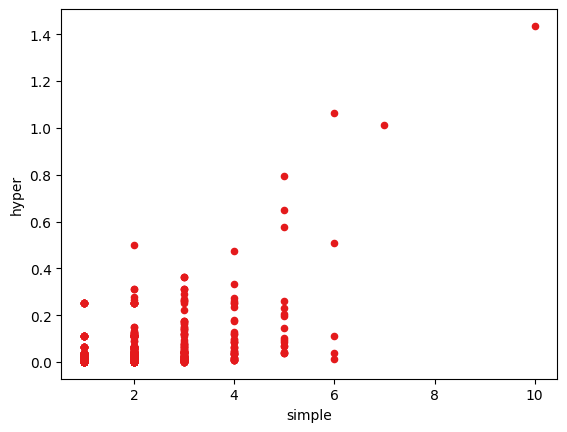

In [16]:
df = pd.DataFrame(data = [(e,
                           G_simple.edges[e]["weight"] if e in G_simple.edges else 0, 
                           G_hyper.edges[e]["weight"] if e in G_hyper.edges else 0)
                         for e in all_edges], columns = ("edge", "simple", "hyper"))

df.plot(kind = "scatter", x = "simple", y = "hyper", color = "#e41a1c")
plt.show()